In [24]:
from caches import LFUCache, NonCache, SimpleCache, LRUCache
from cachesim import Status, Request
from cachesim.tools import PBarMixIn
from readers import PopulationReader

In [25]:
count = 1000000
cbase = count // 10
maxsize = cbase // 100
s = 1

HNs = sum([k ** -s for k in range(1, cbase + 1)])
zipf = [k ** -s / HNs for k in range(1, cbase + 1)]

In [26]:
class MySimpleCache(PBarMixIn, SimpleCache):
    pass


class MyNonCache(PBarMixIn, NonCache):
    pass


class MyLFUCache(PBarMixIn, LFUCache):
    pass


class MyLRUCache(PBarMixIn, LRUCache):
    pass


reqs = {}
for cache in [MySimpleCache(maxsize=maxsize), MyNonCache(), MyLFUCache(maxsize=maxsize), MyLRUCache(maxsize=maxsize)]:
    reader = PopulationReader(count, cbase, weights=zipf)

    req = list(cache.map(reader))
    reqs[cache.__class__.__name__] = req

    hit = sum(map(lambda r: r.status == Status.HIT, req))
    print(f"Requests: {len(req)}")
    print(f"CHR: {Request.chr(req) * 100:.2f}%")
    print(f"Bytes sent: {sum(r.size for r in req)} B")
    print()

    x = [r.time for r in req]

MySimpleCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 406918.47it/s]


Requests: 1000000
CHR: 46.41%
Bytes sent: 1000000 B



MyNonCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 337586.91it/s]


Requests: 1000000
CHR: 0.00%
Bytes sent: 1000000 B



MyLFUCache: 100%|██████████| 1000000/1000000 [00:18<00:00, 55373.85it/s]


Requests: 1000000
CHR: 59.29%
Bytes sent: 1000000 B



MyLRUCache: 100%|██████████| 1000000/1000000 [00:03<00:00, 328252.18it/s]


Requests: 1000000
CHR: 50.59%
Bytes sent: 1000000 B



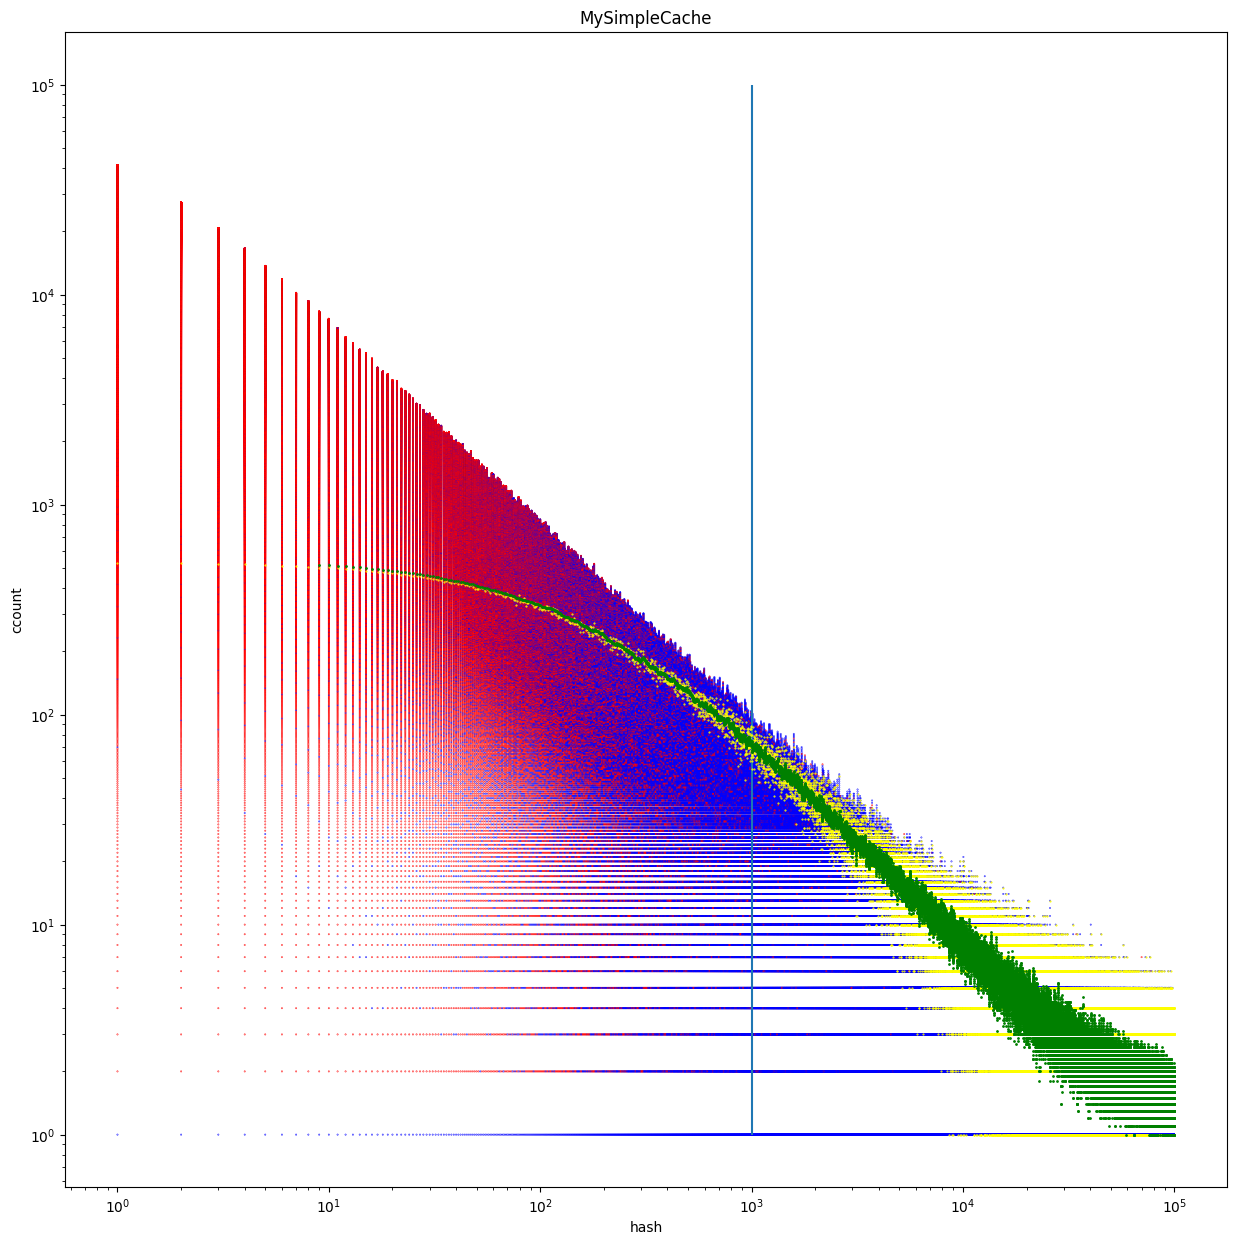

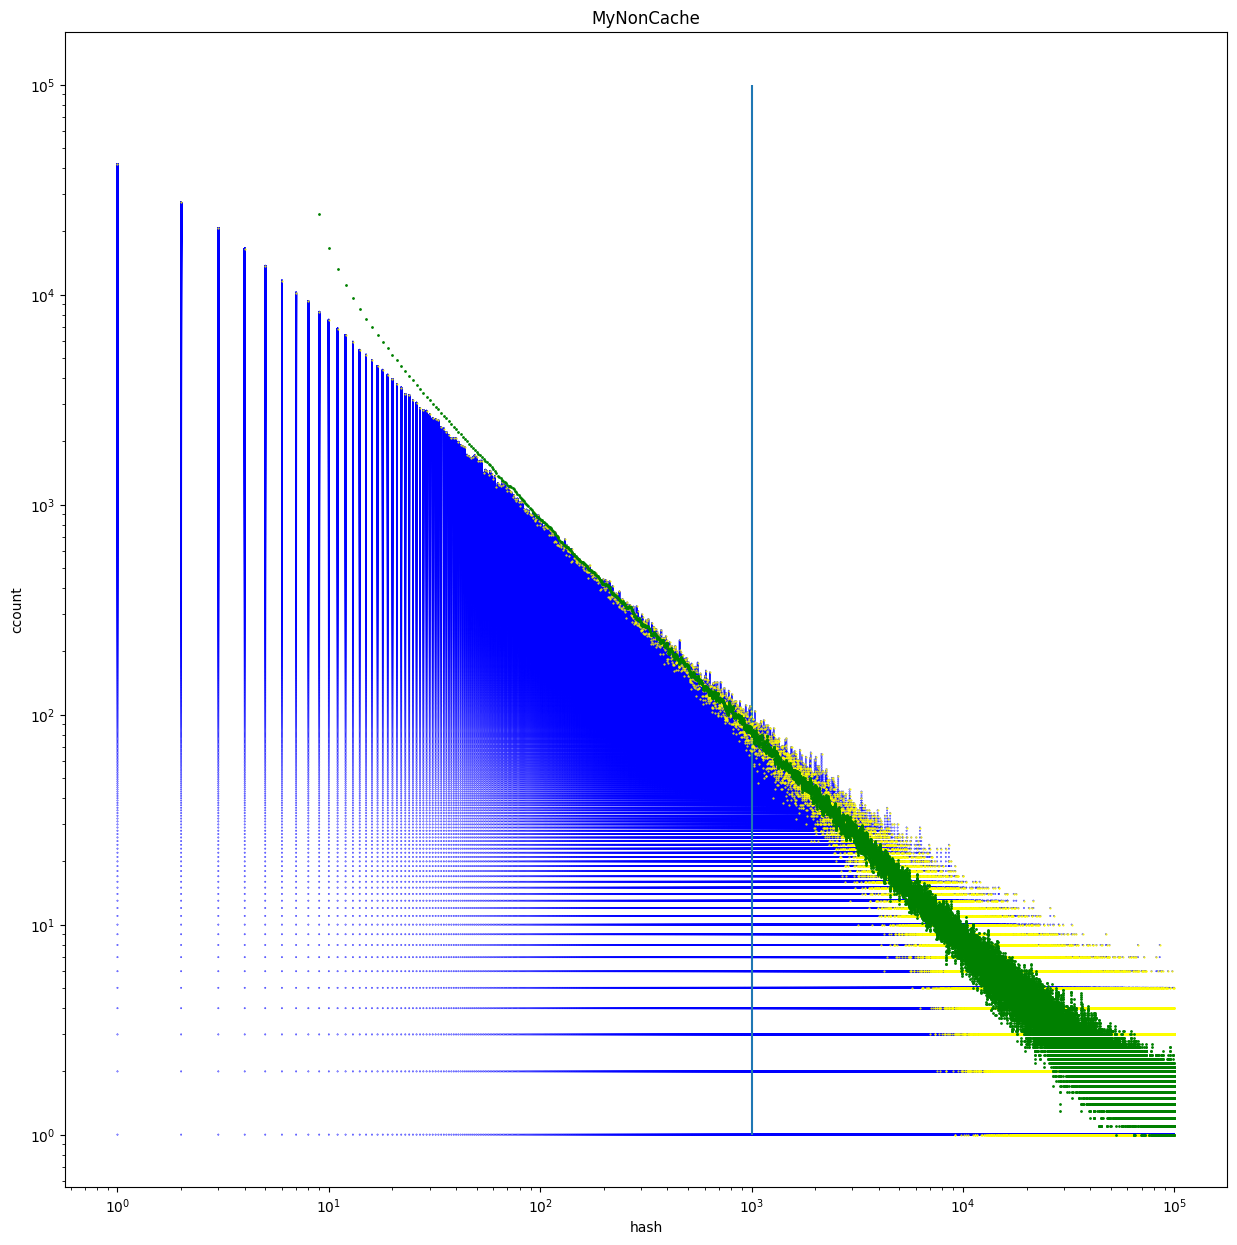

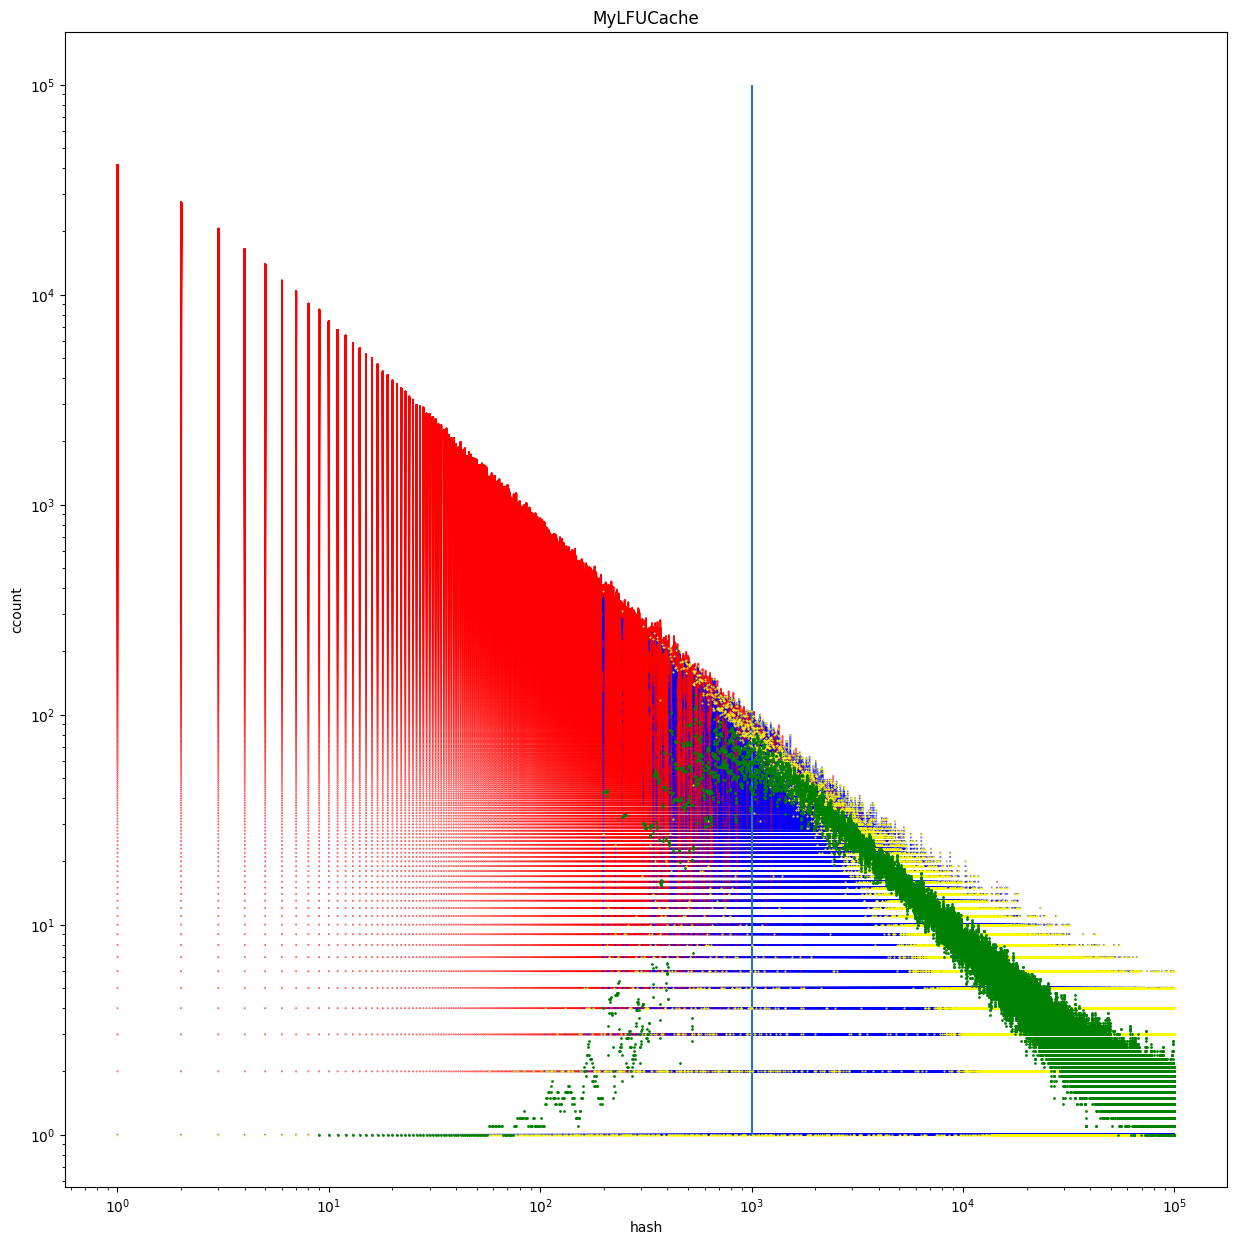

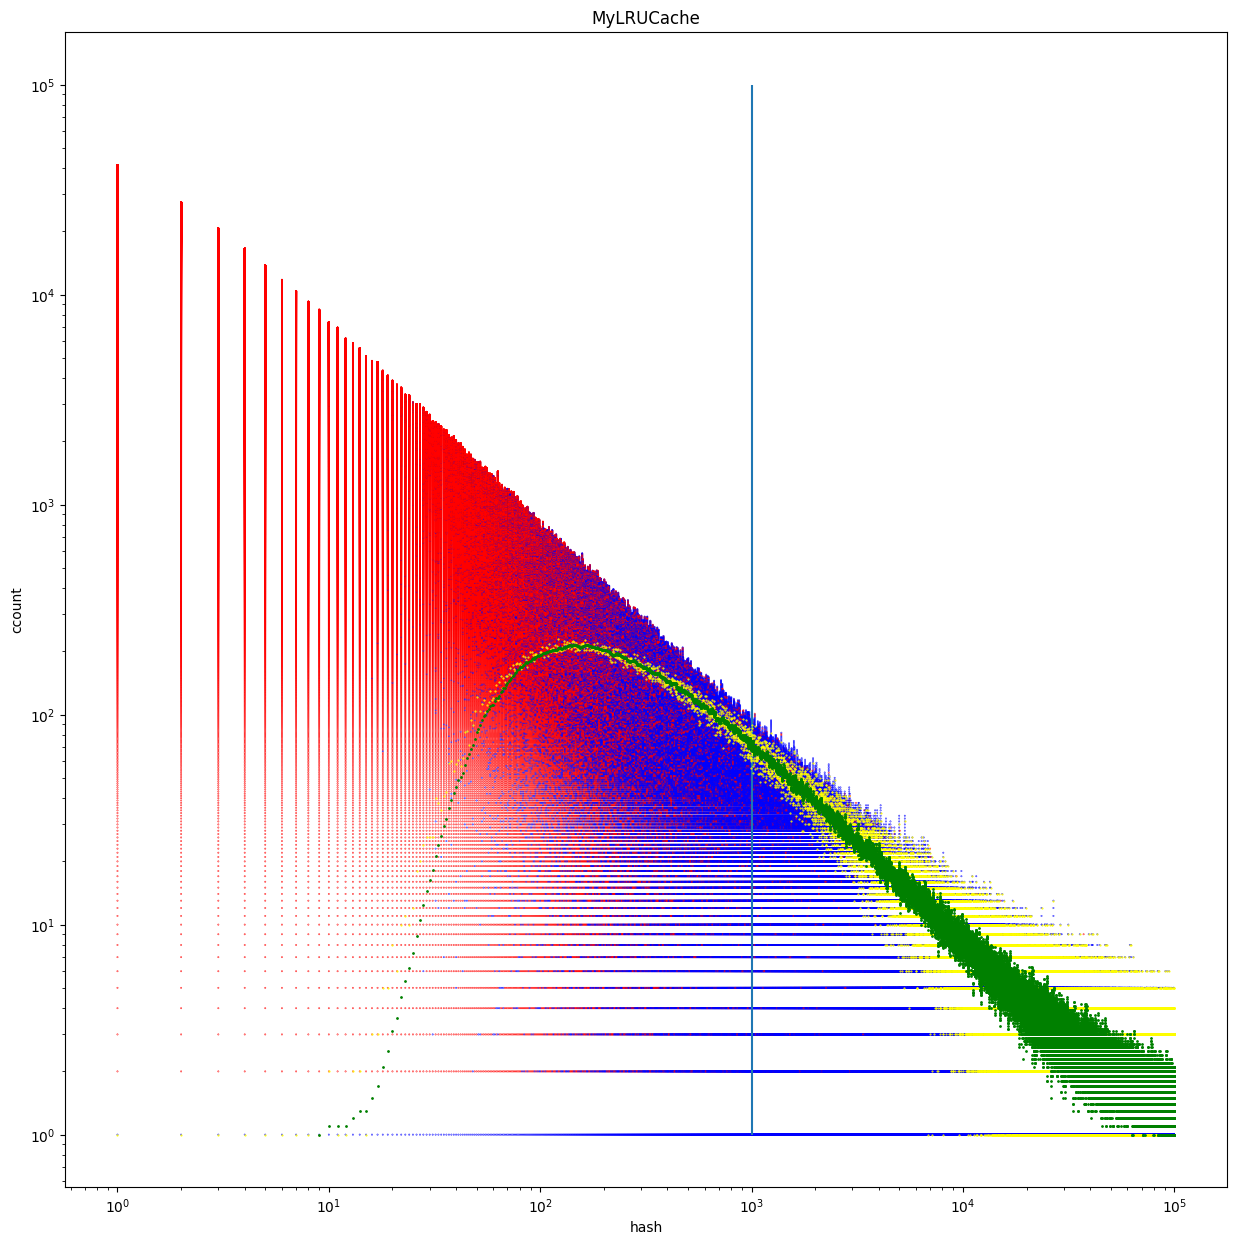

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

for kind, req in reqs.items():
    df = pd.DataFrame(
        data={'hash': [r.hash for r in req], 'hit': ['red' if r.status == Status.HIT else 'blue' for r in req]})
    df['ccount'] = df.groupby('hash').cumcount() + 1
    df.plot.scatter(x="hash", y='ccount', c='hit', s=0.1, loglog=True, figsize=(15, 15), title=kind)
    plt.vlines(maxsize, ymin=1, ymax=10**5)

    df_miss = pd.DataFrame(data={'hash': [r.hash for r in req], 'hit': ['red' if r.status == Status.HIT else 'blue' for r in req]}).value_counts().groupby(['hash', 'hit']).sum()
    df_miss.loc[:,'blue'].plot(loglog=True, c='yellow', style='.', ms=1)
    df_miss.loc[:,'blue'].rolling(10).mean().plot(loglog=True, c='green', style='.', ms=2)


In [60]:
df = pd.DataFrame(data={'hash': [r.hash for r in reqs['MyLFUCache']], 'hit': ['red' if r.status == Status.HIT else 'blue' for r in reqs['MyLFUCache']]}).value_counts().groupby(['hash', 'hit']).sum()
df.loc[:,'blue'].rolling(100).mean().plot(loglog=True)
df


hash   hit 
0      blue        1
       red     82934
1      blue        1
       red     41282
2      blue        1
               ...  
99992  blue        1
99993  blue        1
99996  blue        3
99998  blue        1
99999  blue        2
Name: count, Length: 81805, dtype: int64

<Axes: xlabel='hash'>

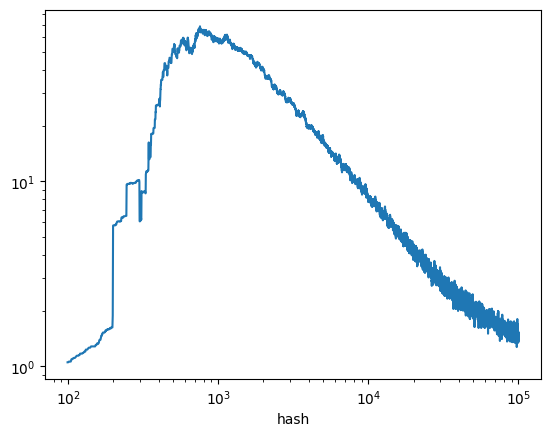